# Content:
1. [Introduction](#1)
2. [Setup](#2)
3. [EDA](#3)
4. [Feature Engineering](#4)
5. [Model](#5)
6. [Predictions](#6)

# <a id="1">Introduction</a>

## What is logistic regression?

This type of statistical model (also known as logit model) is often used for classification and predictive analytics. Logistic regression estimates the probability of an event occurring, such as voted or didn’t vote, based on a given dataset of independent variables. Since the outcome is a probability, the dependent variable is bounded between 0 and 1. In logistic regression, a logit transformation is applied on the odds—that is, the probability of success divided by the probability of failure.

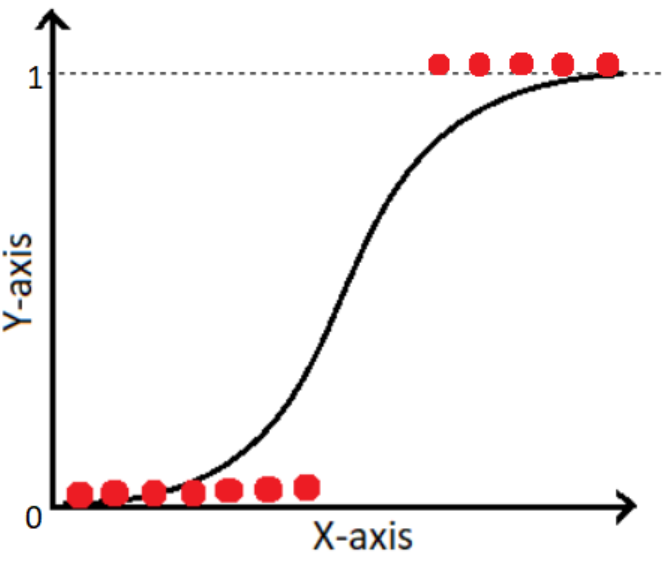

## Project description

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

# <a id="2">Setup</a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
test = pd.read_csv('../input/titanic/test.csv')
train = pd.read_csv('../input/titanic/train.csv')

# <a id="3">EDA</a>

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


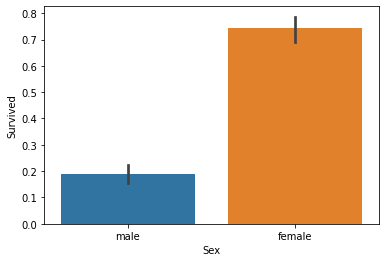

In [6]:
sns.barplot(data = train, x='Sex', y='Survived')
plt.show()

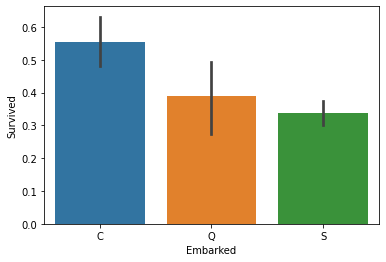

In [7]:
train['Embarked'] = pd.Categorical(train['Embarked'])

sns.barplot(data = train, x='Embarked', y='Survived')
plt.show()

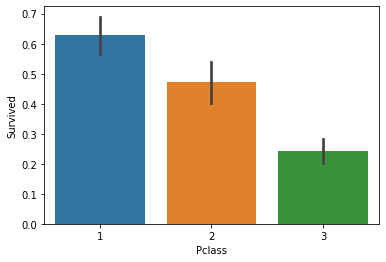

In [8]:
sns.barplot(data = train, x='Pclass', y='Survived')
plt.show()

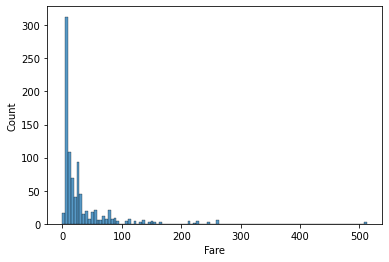

In [9]:
sns.histplot(data= train, x='Fare')
plt.show()

# <a id="4">Feature Engineering</a>

In [10]:
train['Embarked'] = train['Embarked'].cat.codes
print(train['Embarked'])

0      2
1      0
2      2
3      2
4      2
      ..
886    2
887    2
888    2
889    0
890    1
Name: Embarked, Length: 891, dtype: int8


In [11]:
train['Age'] = train['Age'].apply(lambda x: 27.0 if np.isnan(x)==True else x)

In [12]:
train['Age_cat'] = train['Age'].apply(lambda x: '0-6' if x<=6 else ('6-12' if x<=12 else ('12-18') if x<=18 else ('18-24') if x<=24 else ('24-30' if x<=30 else ('30-40' if x<=40 else ('40-55' if x<=55 else '55+')))))
train['Age_cat'] = pd.Categorical(train['Age_cat'])
train['Age_cat'] = train['Age_cat'].cat.codes

In [13]:
train['Family'] = train['SibSp'] + train['Parch']
train['Family'] = train['Family'].apply(lambda x: 1 if x>0 else 0)

In [14]:
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.')
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [15]:
train['Title'] = train['Title'].apply(lambda x: 'Miss' if (x == 'Ms')|(x=='Miss')|(x=='Mlle') else ('Mrs' if (x == 'Mrs')|(x=='Mme') else ('Mr' if x=='Mr' else ('Master' if x=='Master' else 'Other'))))
train['Title'] = pd.Categorical(train['Title'])
train['Title'] = train['Title'].cat.codes

In [16]:
train['Sex'] = train['Sex'].apply(lambda x: 0 if x=='male' else 1)

In [17]:
print(train.shape)
print(test.shape)

(891, 15)
(418, 11)


In [18]:
y = train['Survived']
print(y)

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64


In [19]:
X = train[['Sex', 'Pclass', 'Fare', 'Embarked', 'Title', 'Family']]
print(X)
feature_list = list(X.columns)

     Sex  Pclass     Fare  Embarked  Title  Family
0      0       3   7.2500         2      2       1
1      1       1  71.2833         0      3       1
2      1       3   7.9250         2      1       0
3      1       1  53.1000         2      3       1
4      0       3   8.0500         2      2       0
..   ...     ...      ...       ...    ...     ...
886    0       2  13.0000         2      4       0
887    1       1  30.0000         2      1       0
888    1       3  23.4500         2      1       1
889    0       1  30.0000         0      2       0
890    0       3   7.7500         1      2       0

[891 rows x 6 columns]


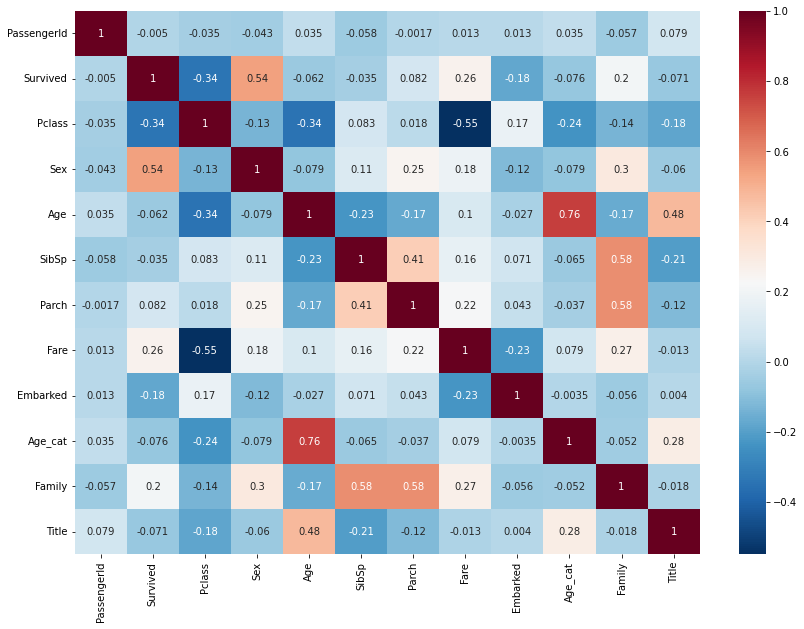

In [20]:
corr_matrix = train.corr(method='pearson')  # 'pearson' is default
 
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()

## Scaling

In [21]:
standard_scaler_fit = StandardScaler().fit(X)
X = standard_scaler_fit.transform(X)

## Splitting the data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# <a id="5">Model</a>

In [23]:
cc_lr = LogisticRegression()

In [24]:
distributions = {'penalty': ['l1', 'l2'], 'C': uniform(loc=0, scale=100)}

## Randomized search on hyperparameters

In [25]:
lr = LogisticRegression(solver = 'liblinear', max_iter = 1000)
clf = RandomizedSearchCV(lr, distributions, n_iter=8)
clf.fit(X_train, y_train) 

RandomizedSearchCV(estimator=LogisticRegression(max_iter=1000,
                                                solver='liblinear'),
                   n_iter=8,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7a50c80c2450>,
                                        'penalty': ['l1', 'l2']})

In [26]:
print(clf.best_params_, clf.best_score_)

{'C': 50.744227552580334, 'penalty': 'l2'} 0.7683344824189895


## Best model

In [27]:
clf_best = LogisticRegression(C = clf.best_params_['C'])
clf_best.fit(X_train,y_train)

LogisticRegression(C=50.744227552580334)

In [28]:
clf_best.score(X_test, y_test)

0.8212290502793296

# <a id="6">Submission</a>

In [29]:
test['Age'].median()
test['Sex'] = test['Sex'].apply(lambda x: 0 if x=='male' else 1)
test['Age'] = test['Age'].apply(lambda x: 27.0 if np.isnan(x)==True else x)
test['Age_cat'] = test['Age'].apply(lambda x: '0-6' if x<=6 else ('6-12' if x<=12 else ('12-18') if x<=18 else ('18-24') if x<=24 else ('24-30' if x<=30 else ('30-40' if x<=40 else ('40-55' if x<=55 else '55+')))))
test['Age_cat'] = pd.Categorical(test['Age_cat'])
test['Age_cat'] = test['Age_cat'].cat.codes
test['Embarked'] = pd.Categorical(test['Embarked'])
test['Embarked'] = test['Embarked'].cat.codes
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.')
test['Title'] = test['Title'].apply(lambda x: 'Miss' if (x == 'Ms')|(x=='Miss')|(x=='Mlle') else ('Mrs' if (x == 'Mrs')|(x=='Mme') else ('Mr' if x=='Mr' else ('Master' if x=='Master' else 'Other'))))
test['Title'] = pd.Categorical(test['Title'])
test['Title'] = test['Title'].cat.codes
test['Family'] = test['SibSp'] + test['Parch']
test['Family'] = test['Family'].apply(lambda x: 1 if x>0 else 0)
test_X = test[['Sex', 'Pclass', 'Fare', 'Embarked', 'Title', 'Family']]

In [30]:
pd.DataFrame(test_X).fillna(0, inplace=True)
median = test_X.median()
test_X['Fare'] = test_X['Fare'].fillna(median)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
df = pd.DataFrame()
test_X = StandardScaler().fit_transform(test_X)
df['PassengerId'] = test['PassengerId']
df['Survived'] = clf_best.predict(test_X)

In [32]:
df.to_csv('submission.csv',index=False)